# 4 Preprocessing and Modeling Part 2

## 4.1 Contents<a id='4.1_Contents'></a>

* [4 Preprocessing and Modeling Part 2](#4_Preprocessing_and_Modeling_Part_2)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
    * [4.2.1 Recap Of Data Science Problem](#4.2.1_Recap_Of_Data_Science_Problem)
    * [4.2.2 Introduction to Notebook](#4.2.2_Introduction_to_Notebook)
  * [4.3 Objectives](#4.3_Objectives)
  * [4.4 Imports](#4.4_Imports)
  * [4.5 Load, Subsample, and Preprocess Data](#4.5_Load,_Subsample,_and_Preprocess_Data)
  * [4.6 Train the Naive Bayes Model](#4.6_Train_the_Naive_Bayes_Model)
    * [4.6.1 Set Up the Pipeline and Train](#4.6.1_Set_Up_the_Pipeline_and_Train)
      * [4.6.1.1 Make Predictions](#4.6.1.1_Make_Predictions)
    * [4.6.2 Optimize Model with GridSearchCV](#4.6.2_Optimize_Model_with_GridSearchCV)
      * [4.6.2.1 Make Predictions](#4.6.2.1_Make_Predictions)
  * [4.7 Train the Support Vector Machine Model and Predict](#4.7_Train_the_Support_Vector_Machine_Model_and_Predict)
  * [4.8 Concluding Remarks](#4.7_Concluding_Remarks)

## 4.2 Introduction<a id='4.2_Introduction'></a>

### 4.2.1 Recap of Data Science Problem<a id='4.2.1_Recap_Of_Data_Science_Problem'></a>

The mission of GlobalGiving is “to transform aid and philanthropy to accelerate community-led change.” To do this, GlobalGiving provides a web-based fundraising platform that supports nonprofits by connecting them with donors and companies. A nonprofit organization can use this platform to pitch their charitable projects on the GlobalGiving website to potential donors. Donors can browse on the website and select from a variety of projects to contribute to. Since 2002, more than 1.1M donors on GlobalGiving have donated more than $530 million to support more than 28,000 projects in 170 countries. 
The nonprofit organizations pitch their development projects by describing the mission and long-term impact of the project in the project description. Based on the nature of the project, GlobalGiving organizes the projects by themes such as education, gender equality, child protection, economic growth, among others. Currently, there are 14,720 active projects organized under 28 different themes. It can be tedious, expensive, and time-consuming to manually assign each project to a theme. Therefore, the goal of this capstone project is to use machine learning to assign a project to a theme.

### 4.2.2 Introduction to Notebook<a id='4.2.2_Introduction_to_Notebook'></a>

In the prior notebook I used the TF-IDF word embedding technique to convert texts into feature vectors that could be used to train the machine learning algorithms. The accuracy of the Naive Bayes model was improved from 0.68 to 0.76 by tuning the variance smoothing parameter of the algorithm. While fitting the Naïve Bayes model took about an hour with hyperparameter tuning, fitting a linear SVM model took about 8 hours with no hyperparameter tuning. The average accuracy is 0.84, which is 8% higher than the best Naïve Bayes model previously discussed. The SVM model classified the ‘Education’ projects better than the Naïve Bayes model by 20%. While both Bag-of-Words and TF-IDF are the most popular word-embedding methods, there a number of drawbacks: (1) They don't capture the context of the words and their similarity, (2) if the new sentences contain new words, then our vocabulary size would increase and thereby, the length of the vectors would increase too, making the dataset very sparse. This affects the efficiency of the training. To improve the efficiency of the model and better capture the context of words and their similarity, in this notebook I will use the word2vec word-embedding method, which allows me to choose the size of the word vector.

## 4.3 Objectives<a id='4.3_Objectives'></a>

1. Subsample 2500 projects from the 'Education', 'Gender Equality', 'Economic Growth', and 'Physical Health' themes
2. Preprocess the data using the word2vec word-embedding method
3. Train a Naive Bayes and Support Vector Machine model
4. Optimize the models using GridSearchCV

## 4.4 Imports<a id='4.4_Imports'></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from mlxtend.preprocessing import DenseTransformer
import math
import gensim
import spacy
import sklearn_evaluation

## 4.5 Load, Subsample, and Preprocess Data<a id='4.5_Load,_Subsample,_and_Preprocess_Data'></a>

In [2]:
# the supplied CSV data files are in the data/raw directory
#load data
df = pd.read_csv('../data/raw/data3.csv')

# drop unnecessary columns
df = df.drop('Unnamed: 0', axis=1)

In [3]:
df.head()

,project_id,active,language,text,theme
0,22244,False,en,save life street dog afghanistan street dog th...,Animal Welfare
1,30154,False,en,save street dog death afghanistan dog thousand...,Animal Welfare
2,33084,False,en,save canine human live afghanistan rabies dead...,Animal Welfare
3,35906,False,en,green tanzania green tanzania project design h...,Animal Welfare
4,41112,False,en,help nowzad reduce rabies afghanistan rabies p...,Animal Welfare


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38188 entries, 0 to 38187
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   project_id  38188 non-null  int64 
 1   active      38188 non-null  bool  
 2   language    38188 non-null  object
 3   text        38188 non-null  object
 4   theme       38188 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 1.2+ MB


**<font color='teal'>From the dataset, select those frmo the 'Education', 'Physical Health', 'Gender Equality', and 'Economic Growth' themes.</font>**

In [5]:
df = df.loc[df['theme'].isin(['Education', 'Physical Health', 'Gender Equality', 'Economic Growth'])]

**<font color='teal'>Select 2500 projects from each theme. This subsample will be used for training and testing.</font>**

In [6]:
select_themes = list(df.theme.unique())
list_of_rows = []

for theme in select_themes:
    np.random.seed(1)
    rows = list(np.random.choice(df[df['theme'] == theme].index.values, 2500))
    list_of_rows = list_of_rows + rows

array_of_rows = np.array(list_of_rows)
df = df.loc[array_of_rows]

In [7]:
df[['text','theme']]

,text,theme
8368,lifeskills beekeeping train girl kenya help gi...,Economic Growth
7542,hope soil project aim use agriculture mean fig...,Economic Growth
8403,support kenyan youth sustainable livelihood pr...,Economic Growth
8212,provide bag make skill marginalize girl twenty...,Economic Growth
10070,care leaver christmas please close gap congrat...,Economic Growth
...,...,...
31070,help u save dad nearly men die prostate cancer...,Physical Health
28326,improve nursing midwifery care liberia urgent ...,Physical Health
26652,equip midwife remote congolese village woman k...,Physical Health
28744,keep infant warm heart surgery surgeon hope fo...,Physical Health


**<font color='teal'>First, I will do a demonstration of splitting the data into training and testing sets. Then I will use the word2vec technique to transform the text into feature vectors.</font>**

In [8]:
X = df['text']
y = df['theme']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=47)

In [9]:
nlp = spacy.load('en_core_web_md')
X_train_vect = X_train.apply(lambda x: nlp(x).vector)
X_train_vect

23826    [0.58432204, 0.29135075, -3.1619077, 0.3513749...
25848    [0.325747, 0.96325046, -1.9238243, 0.11242253,...
25366    [-0.50571996, 1.1757956, -2.0299573, -0.811289...
27960    [0.39523858, 0.7783694, -2.2919142, -0.6147267...
22859    [-0.49792665, 0.8405995, -1.576022, -0.3516383...
                               ...                        
20105    [-0.6071888, 1.1933632, -2.0089889, 0.3686534,...
27463    [-0.19628605, 1.3184856, -1.6092541, 0.1262828...
22944    [-0.29190427, -0.30274248, -3.1383572, 0.73676...
9578     [-0.23000449, 0.53823876, -2.3375294, -0.16251...
21879    [0.21881576, 0.7881491, -2.4792395, -0.4317351...
Name: text, Length: 7000, dtype: object

## 4.6 Train the Naive Bayes Model<a id='4.6_Train_the_Naive_Bayes_Model'></a>

**<font color='teal'>Next, I will fit a Gaussian Naive Bayes model on the training data. The average accuracy for the training dataset is 0.70. </font>**

                 precision    recall  f1-score   support

Economic Growth       0.69      0.72      0.71      1739
      Education       0.71      0.72      0.71      1733
Gender Equality       0.62      0.61      0.62      1746
Physical Health       0.79      0.76      0.77      1782

       accuracy                           0.70      7000
      macro avg       0.70      0.70      0.70      7000
   weighted avg       0.70      0.70      0.70      7000



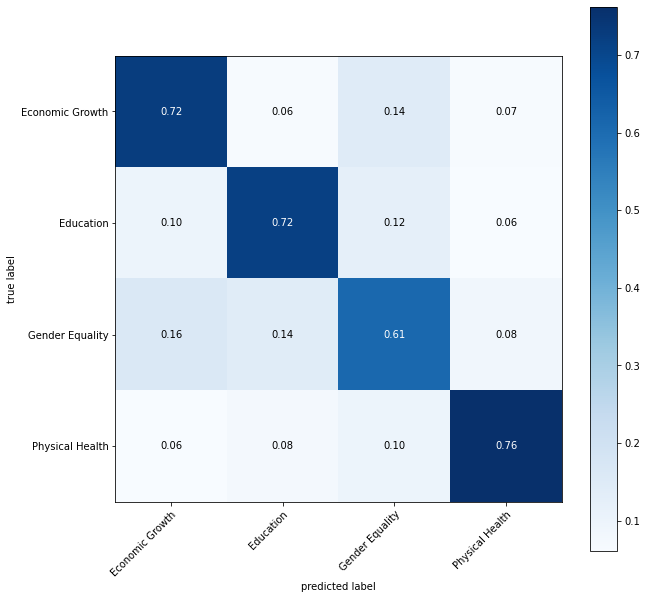

In [10]:
pipe = Pipeline([('NB', GaussianNB())])

pipe.fit(list(X_train_vect),y_train)
predicted_NB = pipe.predict(list(X_train_vect))
print(classification_report(y_train, predicted_NB))
multiclass = confusion_matrix(y_train, predicted_NB)

class_names = pipe.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

**<font color='teal'>Here I use cross-validation to further assess the performance of the model. We find that the accuracy varies from 0.70 to 0.71. </font>**

In [86]:
pipe = Pipeline([('NB', GaussianNB())])

cv_results = cross_validate(pipe, list(X_train_vect), y_train, cv=5, scoring ='accuracy')
cv_scores = cv_results['test_score']
cv_scores

array([0.70142857, 0.71142857, 0.70571429, 0.68357143, 0.69214286])

#### 4.6.1.1 Make Predictions<a id='4.6.1.1_Make_Predictions'></a>

**<font color='teal'>Next, I will look at the performance of the model on the testing dataset, which is shown in the classification report and the confusion matrix. The average accuracy for the testing dataset is 0.71, which is only 0.01 higher than that for the training dataset. </font>**

                 precision    recall  f1-score   support

Economic Growth       0.74      0.70      0.72       761
      Education       0.70      0.72      0.71       767
Gender Equality       0.65      0.66      0.65       754
Physical Health       0.77      0.78      0.78       718

       accuracy                           0.71      3000
      macro avg       0.71      0.71      0.71      3000
   weighted avg       0.71      0.71      0.71      3000



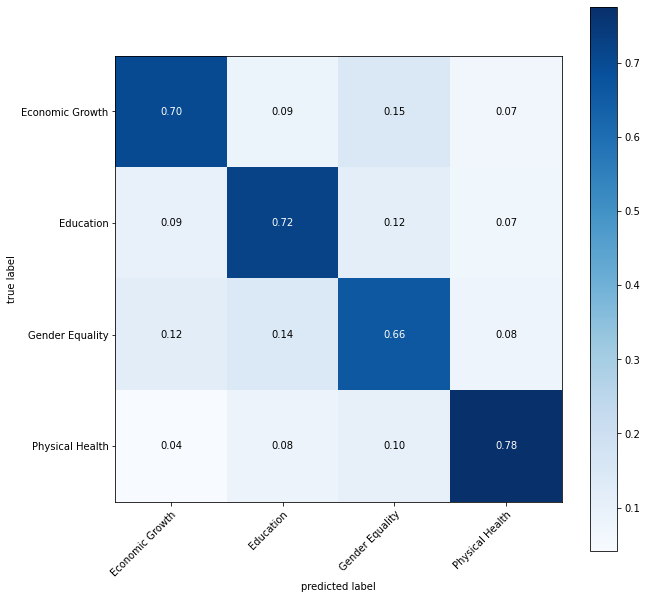

In [11]:
X_test_vect = X_test.apply(lambda x: nlp(x).vector)

pipe.fit(list(X_test_vect),y_test)
predicted_NB = pipe.predict(list(X_test_vect))
print(classification_report(y_test, predicted_NB))
multiclass = confusion_matrix(y_test, predicted_NB)

class_names = pipe.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

### 4.6.2 Optimize Model with GridSearchCV<a id='4.6.2_Optimize_Model_with_GridSearchCV'></a>

**<font color='teal'>To optimize the Naïve Bayes model, I used GridSearchCV to tune the variance smoothing parameter of the Gaussian Naïve Bayes algorithm.</font>**

In [88]:
pipe = Pipeline([('gaussiannb', GaussianNB())])

parameters = {
    'gaussiannb__var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}
clf_cv = GridSearchCV(pipe, cv = 5, param_grid = parameters, verbose = 1, n_jobs=-1, scoring ='accuracy')
clf_cv.fit(list(X_train_vect), y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('gaussiannb', GaussianNB())]),
             n_jobs=-1,
             param_grid={'gaussiannb__var_smoothing': [0.01, 0.001, 0.0001,
                                                       1e-05, 1e-06, 1e-07,
                                                       1e-08, 1e-09, 1e-10,
                                                       1e-11, 1e-12, 1e-13,
                                                       1e-14, 1e-15]},
             scoring='accuracy', verbose=1)

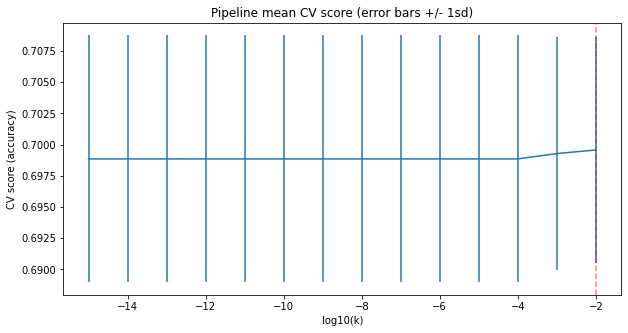

In [89]:
score_mean = clf_cv.cv_results_['mean_test_score']
score_std = clf_cv.cv_results_['std_test_score']
cv_k = [math.log10(k) for k in clf_cv.cv_results_['param_gaussiannb__var_smoothing']]
best_k = math.log10(clf_cv.best_params_['gaussiannb__var_smoothing'])
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('log10(k)')
plt.ylabel('CV score (accuracy)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

**<font color='teal'>Here we see that the accuracy did not improve significantly and maintains at a value of 0.70. Therefore, the value for the variance smoothing parameter does not have a significant effect on the accuracy of the Naive Bayes model. Below we find that the optimized Naive Bayes model has an average accuracy of 0.70 for the training set and 0.71 for the testing set. As for prior models, the Niave Bayes model misclassifies "Gender Equality" projects more compared to projects under other themes.</font>**

                 precision    recall  f1-score   support

Economic Growth       0.69      0.73      0.71      1739
      Education       0.71      0.72      0.72      1733
Gender Equality       0.62      0.61      0.62      1746
Physical Health       0.79      0.76      0.77      1782

       accuracy                           0.70      7000
      macro avg       0.70      0.70      0.70      7000
   weighted avg       0.70      0.70      0.70      7000



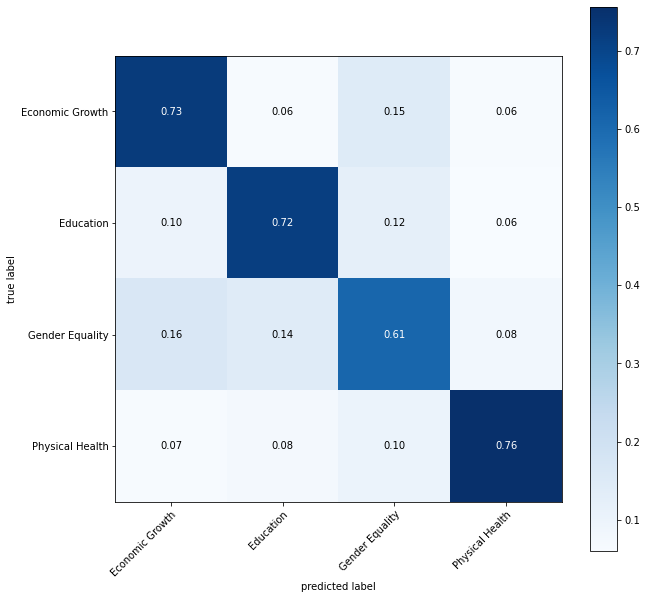

In [93]:
predicted_NB = clf_cv.predict(list(X_train_vect))
print(classification_report(y_train, predicted_NB))

multiclass = confusion_matrix(y_train, predicted_NB)

class_names = clf_cv.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

                 precision    recall  f1-score   support

Economic Growth       0.71      0.70      0.70       761
      Education       0.71      0.71      0.71       767
Gender Equality       0.63      0.67      0.65       754
Physical Health       0.79      0.76      0.77       718

       accuracy                           0.71      3000
      macro avg       0.71      0.71      0.71      3000
   weighted avg       0.71      0.71      0.71      3000



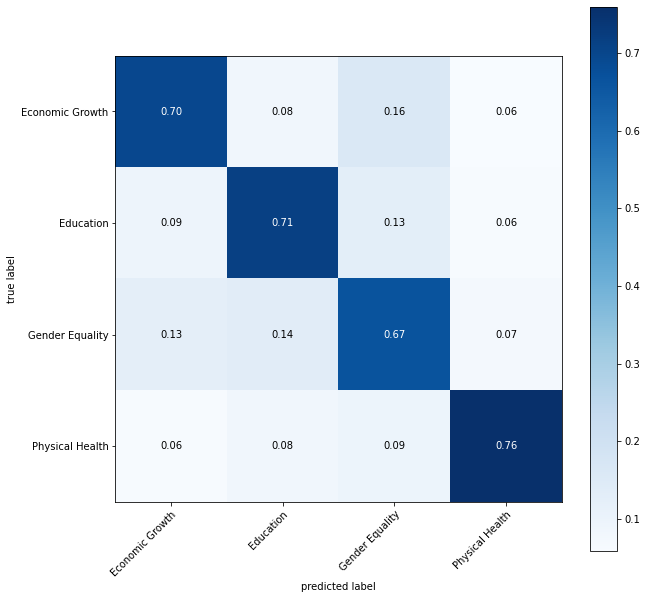

In [94]:
predicted_NB = clf_cv.predict(list(X_test_vect))
print(classification_report(y_test, predicted_NB))

multiclass = confusion_matrix(y_test, predicted_NB)

class_names = clf_cv.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

## 4.7 Train the Support Vector Machine Model and Predict<a id='4.7_Train_the_Support_Vector_Machine_Model_and_Predict'></a>

**<font color='teal'>Here I will fit first a linear, an RBF, and a poly kernel SVM model to the training set. For all models, the average accuracy ranges from 0.77 and 0.78.</font>**

Classification Report for Training Data
                 precision    recall  f1-score   support

Economic Growth       0.84      0.86      0.85      1739
      Education       0.85      0.85      0.85      1733
Gender Equality       0.85      0.84      0.84      1746
Physical Health       0.90      0.88      0.89      1782

       accuracy                           0.86      7000
      macro avg       0.86      0.86      0.86      7000
   weighted avg       0.86      0.86      0.86      7000

Classification Report for Testing Data
                 precision    recall  f1-score   support

Economic Growth       0.74      0.78      0.76       761
      Education       0.77      0.76      0.77       767
Gender Equality       0.78      0.77      0.78       754
Physical Health       0.81      0.78      0.79       718

       accuracy                           0.77      3000
      macro avg       0.78      0.77      0.77      3000
   weighted avg       0.77      0.77      0.77      3000



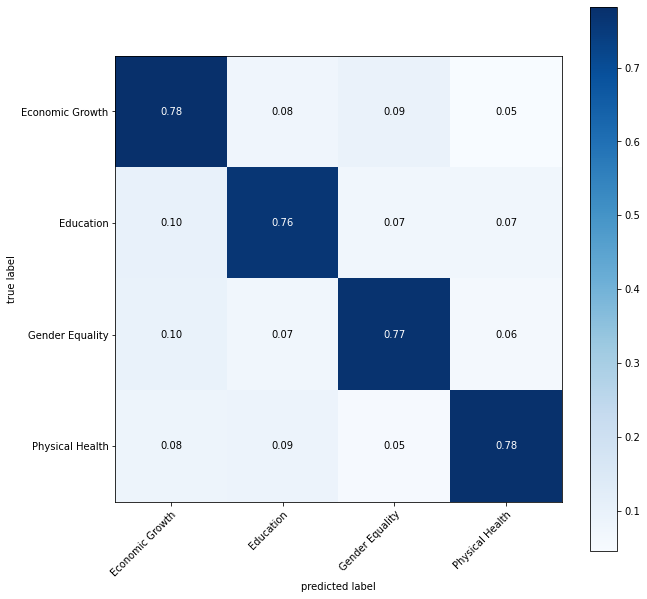

In [95]:
pipe = Pipeline([('SVC', SVC(kernel='linear'))])

pipe.fit(list(X_train_vect),y_train)
predicted_svc = pipe.predict(list(X_train_vect))
print('Classification Report for Training Data')
print(classification_report(y_train, predicted_svc))

predicted_svc = pipe.predict(list(X_test_vect))
print('Classification Report for Testing Data')
print(classification_report(y_test, predicted_svc))

multiclass = confusion_matrix(y_test, predicted_svc)

class_names = pipe.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

Classification Report for Training Data
                 precision    recall  f1-score   support

Economic Growth       0.76      0.77      0.77      1739
      Education       0.77      0.79      0.78      1733
Gender Equality       0.77      0.73      0.75      1746
Physical Health       0.82      0.83      0.82      1782

       accuracy                           0.78      7000
      macro avg       0.78      0.78      0.78      7000
   weighted avg       0.78      0.78      0.78      7000

Classification Report for Testing Data
                 precision    recall  f1-score   support

Economic Growth       0.77      0.75      0.76       761
      Education       0.76      0.78      0.77       767
Gender Equality       0.77      0.75      0.76       754
Physical Health       0.80      0.81      0.80       718

       accuracy                           0.77      3000
      macro avg       0.77      0.77      0.77      3000
   weighted avg       0.77      0.77      0.77      3000



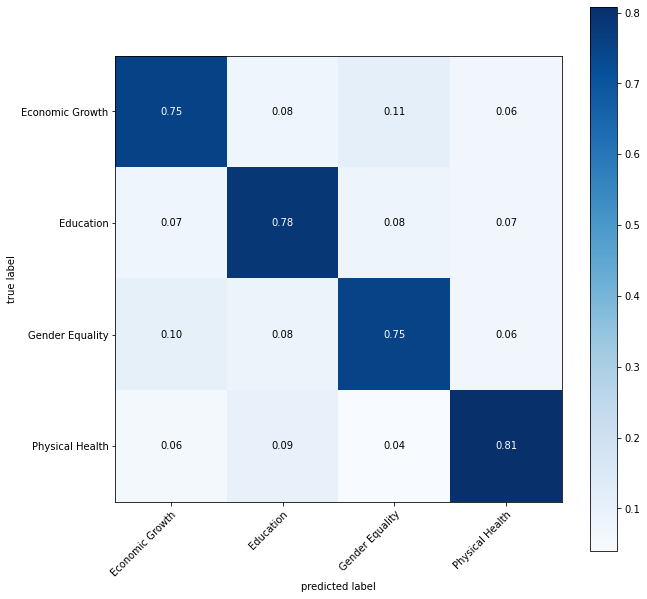

In [97]:
pipe = Pipeline([('SVC', SVC(kernel='rbf'))])

pipe.fit(list(X_train_vect),y_train)
predicted_svc = pipe.predict(list(X_train_vect))
print('Classification Report for Training Data')
print(classification_report(y_train, predicted_svc))

predicted_svc = pipe.predict(list(X_test_vect))
print('Classification Report for Testing Data')
print(classification_report(y_test, predicted_svc))

multiclass = confusion_matrix(y_test, predicted_svc)

class_names = pipe.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

Classification Report for Training Data
                 precision    recall  f1-score   support

Economic Growth       0.78      0.78      0.78      1739
      Education       0.78      0.79      0.79      1733
Gender Equality       0.77      0.75      0.76      1746
Physical Health       0.82      0.84      0.83      1782

       accuracy                           0.79      7000
      macro avg       0.79      0.79      0.79      7000
   weighted avg       0.79      0.79      0.79      7000

Classification Report for Testing Data
                 precision    recall  f1-score   support

Economic Growth       0.78      0.76      0.77       761
      Education       0.78      0.77      0.78       767
Gender Equality       0.76      0.77      0.77       754
Physical Health       0.80      0.81      0.80       718

       accuracy                           0.78      3000
      macro avg       0.78      0.78      0.78      3000
   weighted avg       0.78      0.78      0.78      3000



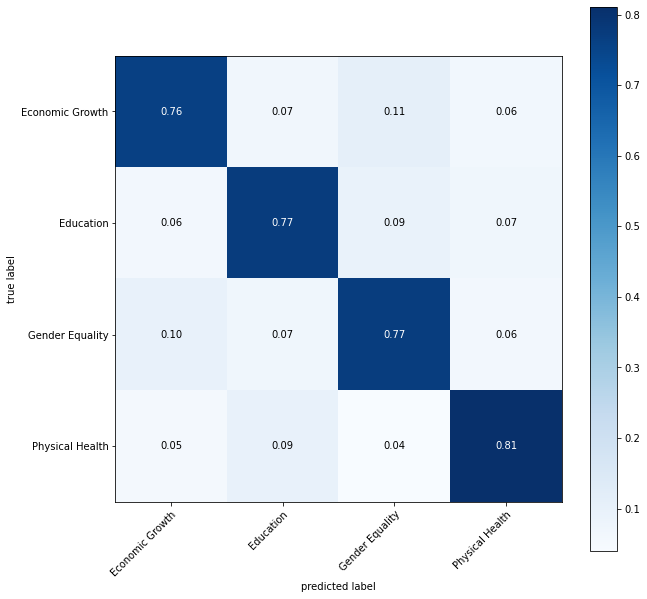

In [98]:
pipe = Pipeline([('SVC', SVC(kernel='poly'))])

pipe.fit(list(X_train_vect),y_train)
predicted_svc = pipe.predict(list(X_train_vect))
print('Classification Report for Training Data')
print(classification_report(y_train, predicted_svc))

predicted_svc = pipe.predict(list(X_test_vect))
print('Classification Report for Testing Data')
print(classification_report(y_test, predicted_svc))

multiclass = confusion_matrix(y_test, predicted_svc)

class_names = pipe.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

### 4.7.2 Optimize Model with GridSearchCV<a id='4.7.2_Optimize_Model_with_GridSearchCV'></a>

**<font color='teal'>To optimize the SVM model, I used GridSearchCV to vary the type of kernel and tune the gamma and C values of the algorithm.</font>**

In [14]:
pipe = Pipeline([('SVC', SVC())])

parameters = {
    'SVC__kernel': ['linear', 'poly', 'rbf'],
    'SVC__gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'SVC__C' : [0.1, 1, 10, 100]
}

clf_cv = GridSearchCV(pipe, cv = 3, param_grid = parameters, verbose = 1, n_jobs=-1, scoring ='accuracy')
clf_cv.fit(list(X_train_vect), y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=Pipeline(steps=[('SVC', SVC())]), n_jobs=-1,
             param_grid={'SVC__C': [0.1, 1, 10, 100],
                         'SVC__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'SVC__kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy', verbose=1)

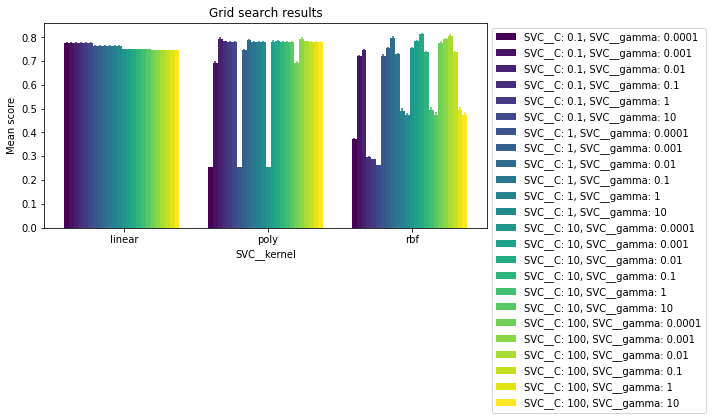

In [63]:
plt.subplots(figsize=(10, 5))
sklearn_evaluation.plot.grid_search(clf_cv.cv_results_, change='SVC__kernel', kind='bar')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()

**<font color='teal'>Here we find that the best performing kernel is RBF and the most optimal parameter values are a C value of 10 and a gamma value of 0.01. We also find that a linear SVM model with a C value of 0.1 performs well with an accuracy of nearly 0.80. A linear SVM model may be more beneficial with a larger dataset that would otherwise take longer train and test with an RBF SVM model.</font>**

In [16]:
clf_cv.best_params_

{'SVC__C': 10, 'SVC__gamma': 0.01, 'SVC__kernel': 'rbf'}

Classification Report for Training Data
                 precision    recall  f1-score   support

Economic Growth       0.99      0.99      0.99      1739
      Education       0.99      0.99      0.99      1733
Gender Equality       0.98      0.99      0.99      1746
Physical Health       1.00      0.99      0.99      1782

       accuracy                           0.99      7000
      macro avg       0.99      0.99      0.99      7000
   weighted avg       0.99      0.99      0.99      7000

Classification Report for Testing Data
                 precision    recall  f1-score   support

Economic Growth       0.83      0.84      0.84       761
      Education       0.84      0.81      0.83       767
Gender Equality       0.83      0.86      0.84       754
Physical Health       0.84      0.83      0.84       718

       accuracy                           0.84      3000
      macro avg       0.84      0.84      0.84      3000
   weighted avg       0.84      0.84      0.84      3000



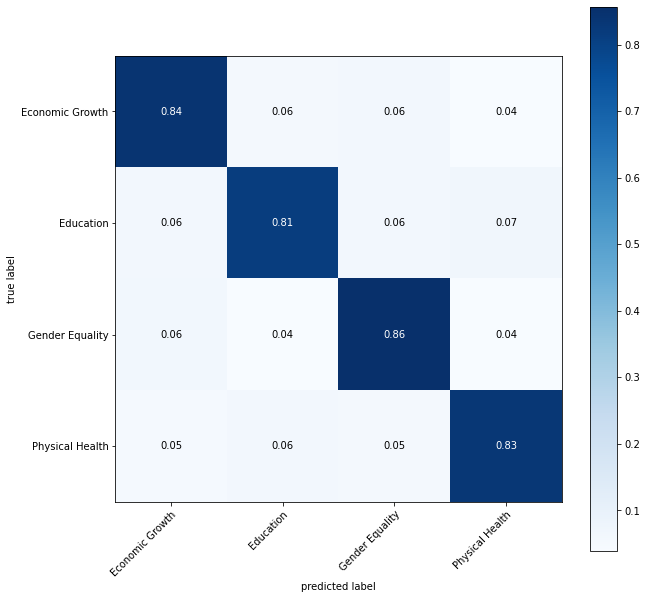

In [17]:
predicted_svc = clf_cv.predict(list(X_train_vect))

print('Classification Report for Training Data')
print(classification_report(y_train, predicted_svc))

predicted_svc = clf_cv.predict(list(X_test_vect))
print('Classification Report for Testing Data')
print(classification_report(y_test, predicted_svc))

multiclass = confusion_matrix(y_test, predicted_svc)

class_names = clf_cv.classes_

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=class_names,
                                figsize = (10,10))
plt.show()

**<font color='teal'>Here we find that the RBF SVM model is 13% more accurate than the Naïve Bayes model and classifies almost 20% more "Gender Equality" projects correctly compared to the Naive Bayes model.</font>**

## 4.8 Concluding Remarks<a id='4.7_Concluding_Remarks'></a>

the goal of this capstone project was to use machine learning to assign a project to a theme and streamline the content development process of GlobalGiving using an "auto-tagging system". Such auto-tagging system can also be used in a metadata management system that offers options and solutions on how to best tag a project such that the nonprofit attracts and retains the most ideal donors. After training and optimizing different models, I found that a combination of the word2vec word-embedding method an a SVM model classifies best the ‘Education’, ‘Gender Equality’, ‘Economic Growth’, and ‘Physical Health’ projects. Because the word2vec method results in a less sparse dataset, the next step would be to apply the word2vec word-embedding method to the entire dataset of containing all 38,811 projects and fit a SVM model. Depending on how accurate this model is, the challenges of this next step will continue to be distinguishing among projects with similar language and identifying a metric that can assess how correctly the model classifies these projects, but also gives merit to partially correct classification.